**<h1>Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной</h1>**

**<h3>Задача 1</h3>**

In [51]:
# загрузка пакетов
import numpy as np
import random

In [52]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(11)
# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.85 # параметры распределения X
x_min, x_max = 5, 105 # генерируем X
x = np.random.uniform(x_min, x_max, n_all)
# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)
# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all*train_percent), replace=False)
# истинная функция взаимосвязи
def y_func (x) :
  return (25+0.02*x-0.003*(x-45)**2+0.00006*(x-54)**3)
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)
# фактические значения y (с шумом)
y = y_func(x) + res
# создаём векторы с данными для построения графиков # наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]
# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

In [53]:
# загрузка пакетов
import matplotlib.pyplot as plt

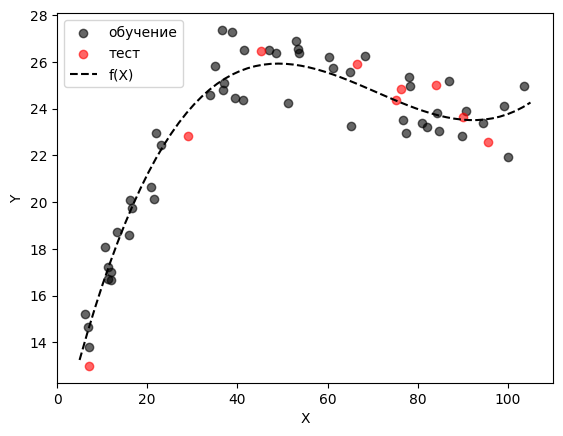

In [54]:
# график 1: исходные данные
# обучающая выборка
plt.scatter(x_train, y_train, c='black', label='обучение', alpha=0.6) # тестовая выборка
plt.scatter(x_test, y_test, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)') # подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.show()

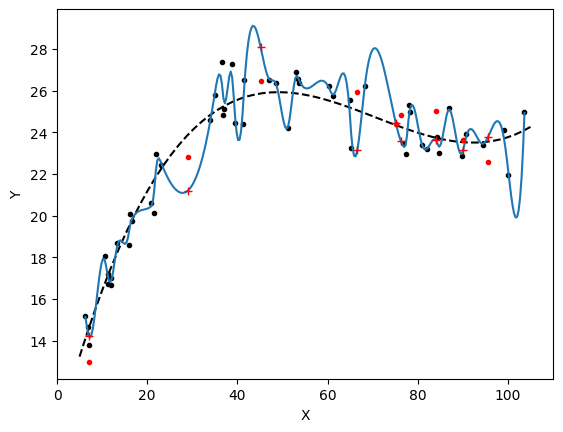

In [55]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38
# сохраняем индексы отсортированного по возрастанию x из обучающей выборк и
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline'] # строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.',
         label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
         label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.',
         label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+',
         label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
           sum((y_test - y_hat_test)**2) / len(y_test)]

In [56]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.17, 2.17])

In [57]:

#  Теперь строим модели с df от 2 до 40 #################################
###
# максимальное число степеней свободы для модели сплайна
max_df = 40
# фрейм данных для сохранения MSE на обучающей и на тестовой
# при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'], index=list(range(2, max_df+1)))
for i_df in range(2, max_df+1) :
# заполняем фрейм
    # обучаем модель
  fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
# прогноз на обучающей выборке
  y_train_hat = np.array(robjects.r['predict'](fit,
      robjects.FloatVector(x_train)).rx2('y'))
# прогноз на тестовой выборке
  y_test_hat = np.array(robjects.r['predict'](fit,
      robjects.FloatVector(x_test)).rx2('y'))
# считаем MSE
  MSE_all_dfs.loc[i_df, 'MSE_train'] = \
      sum((y_train - y_train_hat)**2) / len(y_train_hat)
  MSE_all_dfs.loc[i_df, 'MSE_test'] = \
      sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [58]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
16,0.747603,0.962478


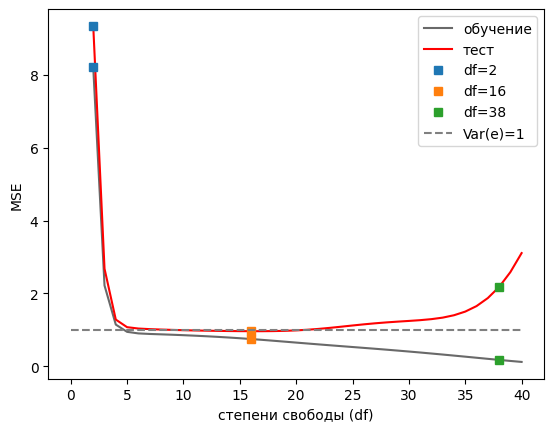

In [66]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
                  MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([16, 16], [MSE_all_dfs.iloc[14]['MSE_train'],
                  MSE_all_dfs.iloc[14]['MSE_test']],
         ls='', marker='s', label='df=16')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
                    MSE_all_dfs.iloc[36]['MSE_test']],
ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1') # подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()

**<h3>Задача 2</h3>**

In [61]:
train_percent1 = 0.2
train_percent2 = 0.15
train_percent3 = 0.1

# отбираем наблюдения в обучающую выборку
in_train1 = np.random.choice(np.arange(n_all), int(n_all*train_percent1), replace=False)
in_train2 = np.random.choice(np.arange(n_all), int(n_all*train_percent2), replace=False)
in_train3 = np.random.choice(np.arange(n_all), int(n_all*train_percent3), replace=False)

# наблюдения на обучающей выборке
x_train1 = x[in_train1]
y_train1 = y[in_train1]

x_train2 = x[in_train2]
y_train2 = y[in_train2]

x_train3 = x[in_train3]
y_train3 = y[in_train3]

# наблюдения на тестовой выборке
x_test1 = np.delete(x, in_train1)
y_test1 = np.delete(y, in_train1)

x_test2 = np.delete(x, in_train2)
y_test2 = np.delete(y, in_train2)

x_test3 = np.delete(x, in_train3)
y_test3 = np.delete(y, in_train3)


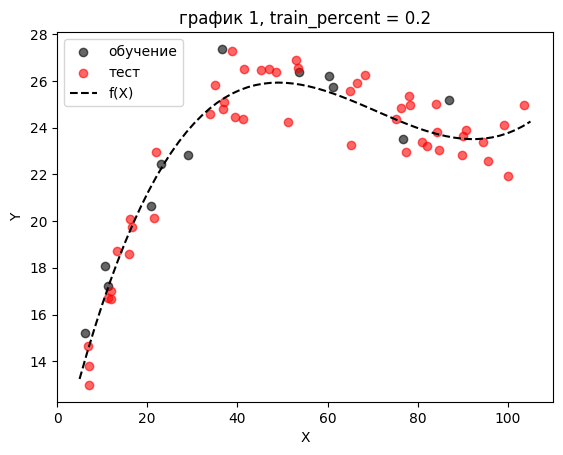

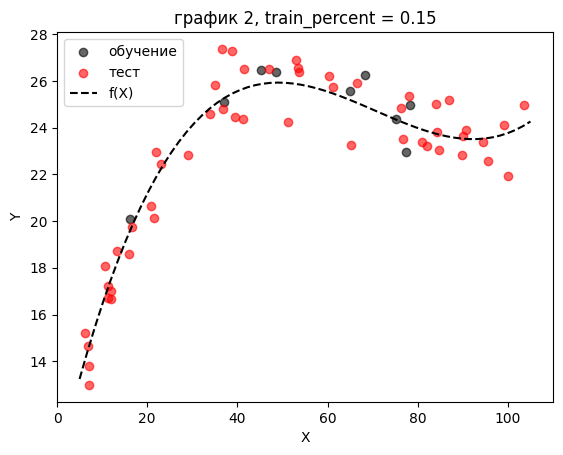

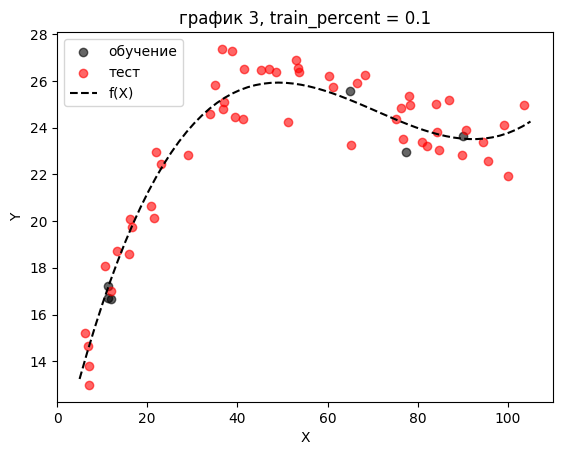

In [62]:
plt.scatter(x_train1, y_train1, c='black', label='обучение', alpha=0.6) # тестовая выборка
plt.scatter(x_test1, y_test1, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)') # подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.title('график 1, train_percent = 0.2')
plt.show()


plt.scatter(x_train2, y_train2, c='black', label='обучение', alpha=0.6) # тестовая выборка
plt.scatter(x_test2, y_test2, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)') # подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.title('график 2, train_percent = 0.15')
plt.show()


plt.scatter(x_train3, y_train3, c='black', label='обучение', alpha=0.6) # тестовая выборка
plt.scatter(x_test3, y_test3, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)') # подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.title('график 3, train_percent = 0.1')
plt.show()

array([0.38, 2.3 ])

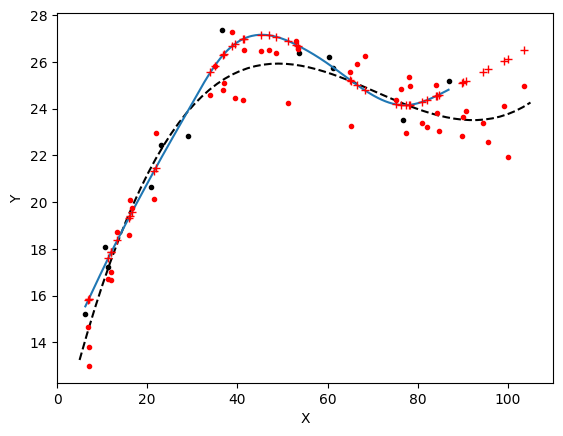

In [63]:
#если train_percent = 0.2

x_sorted_index1 = sorted(range(len(x_train1)), key=lambda k: x_train1[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin1 = np.linspace(min(x_train1), max(x_train1), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x1 = robjects.FloatVector(x_train1)
r_y1 = robjects.FloatVector(y_train1)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline'] # строим сглаживающий сплайн
fit1 = r_smooth_spline(x=r_x1, y=r_y1, df=my_df)
# делаем прогнозы
y_hat_train1 = np.array(robjects.r['predict'](fit1,
    robjects.FloatVector(x_train1)).rx2('y'))
y_hat_test1 = np.array(robjects.r['predict'](fit1,
    robjects.FloatVector(x_test1)).rx2('y'))
y_lin_plot1 = np.array(robjects.r['predict'](fit1,
    robjects.FloatVector(x_train_lin1)).rx2('y'))
# строим график
plt.plot(x_train1, y_train1, color='black', ls='', marker='.',
         label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
         label='f(X)')
plt.plot(x_train_lin1, y_lin_plot1, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test1, y_test1, color='red', ls='', marker='.',
         label='тест факт')
plt.plot(x_test1, y_hat_test1, color='red', ls='', marker='+',
         label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда plt.legend(loc='best')
# считаем MSE
MSE_fit1 = [sum((y_train1 - y_hat_train1)**2) / len(y_train1),
           sum((y_test1 - y_hat_test1)**2) / len(y_test1)]
# фильтруем таблицу по минимальной MSE на тестовой выборке

# выводим MSE с округлением
np.around(MSE_fit1, 2)

array([0.37, 3.29])

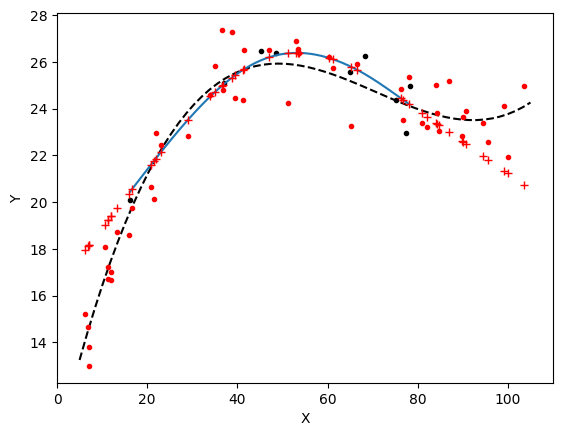

In [64]:
#если train_percent = 0.15

x_sorted_index2 = sorted(range(len(x_train2)), key=lambda k: x_train2[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin2 = np.linspace(min(x_train2), max(x_train2), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x2 = robjects.FloatVector(x_train2)
r_y2 = robjects.FloatVector(y_train2)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline'] # строим сглаживающий сплайн
fit2 = r_smooth_spline(x=r_x2, y=r_y2, df=my_df)
# делаем прогнозы
y_hat_train2 = np.array(robjects.r['predict'](fit2,
    robjects.FloatVector(x_train2)).rx2('y'))
y_hat_test2 = np.array(robjects.r['predict'](fit2,
    robjects.FloatVector(x_test2)).rx2('y'))
y_lin_plot2 = np.array(robjects.r['predict'](fit2,
    robjects.FloatVector(x_train_lin2)).rx2('y'))
# строим график
plt.plot(x_train2, y_train2, color='black', ls='', marker='.',
         label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
         label='f(X)')
plt.plot(x_train_lin2, y_lin_plot2, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test2, y_test2, color='red', ls='', marker='.',
         label='тест факт')
plt.plot(x_test2, y_hat_test2, color='red', ls='', marker='+',
         label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда plt.legend(loc='best')
# считаем MSE
MSE_fit2 = [sum((y_train2 - y_hat_train2)**2) / len(y_train2),
           sum((y_test2 - y_hat_test2)**2) / len(y_test2)]
# фильтруем таблицу по минимальной MSE на тестовой выборке

# выводим MSE с округлением
np.around(MSE_fit2, 2)

array([0.03, 6.95])

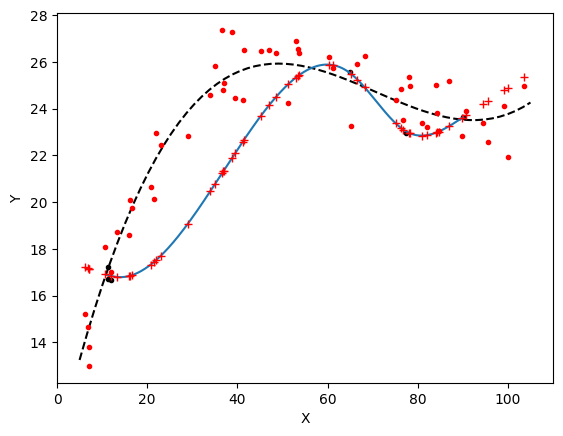

In [65]:
#если train_percent = 0.1

x_sorted_index3 = sorted(range(len(x_train3)), key=lambda k: x_train3[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin3 = np.linspace(min(x_train3), max(x_train3), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x3 = robjects.FloatVector(x_train3)
r_y3 = robjects.FloatVector(y_train3)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline'] # строим сглаживающий сплайн
fit3 = r_smooth_spline(x=r_x3, y=r_y3, df=my_df)
# делаем прогнозы
y_hat_train3 = np.array(robjects.r['predict'](fit3,
    robjects.FloatVector(x_train3)).rx2('y'))
y_hat_test3 = np.array(robjects.r['predict'](fit3,
    robjects.FloatVector(x_test3)).rx2('y'))
y_lin_plot3 = np.array(robjects.r['predict'](fit3,
    robjects.FloatVector(x_train_lin3)).rx2('y'))
# строим график
plt.plot(x_train3, y_train3, color='black', ls='', marker='.',
         label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
         label='f(X)')
plt.plot(x_train_lin3, y_lin_plot3, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test3, y_test3, color='red', ls='', marker='.',
         label='тест факт')
plt.plot(x_test3, y_hat_test3, color='red', ls='', marker='+',
         label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда plt.legend(loc='best')
# считаем MSE
MSE_fit3 = [sum((y_train3 - y_hat_train3)**2) / len(y_train3),
           sum((y_test3 - y_hat_test3)**2) / len(y_test3)]
# фильтруем таблицу по минимальной MSE на тестовой выборке

# выводим MSE с округлением
np.around(MSE_fit3, 2)